## Step 2: Data Exploration:

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
import cv2
from collections import Counter

In [2]:
# Define dataset path
dataset_path = "EuroSAT/2750/"

In [3]:
# List all land type categories
categories = os.listdir(dataset_path)

## Step 3: Data Preprocessing

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
# Resize, normalize, and convert to RGB
def load_and_preprocess_images(path, size=(64, 64)):
    data, labels = [], []
    for category in categories:
        category_path = os.path.join(path, category)
        for img_name in os.listdir(category_path):
            img = cv2.imread(os.path.join(category_path, img_name))
            img = cv2.resize(img, size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = img / 255.0  # Normalize to [0,1]
            data.append(img)
            labels.append(category)
    return np.array(data, dtype="float32"), np.array(labels)

In [6]:
# Load data
data, labels = load_and_preprocess_images(dataset_path, size=(128, 128))

In [7]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
# Encode labels into integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)  # Convert category names to integer labels

In [9]:
# Convert to one-hot encoding
labels_categorical = to_categorical(labels_encoded)

In [10]:
# Split dataset into train (70%), validation (20%), and test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels_categorical, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

In [11]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    # shear_range=15,
)


# datagen = ImageDataGenerator(
#     rotation_range=25,    # Slightly increased, but not too much
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     shear_range=0.1  # Just a little shear (not too aggressive)
# )


# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     zoom_range=0.2,
#     shear_range=0.15,   # Skewing effect for robustness
#     brightness_range=[0.8, 1.2],  # simulates lighting variation
# )

In [12]:
val_test_datagen = ImageDataGenerator()

# Final datasets
train_generator = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = val_test_datagen.flow(X_val, y_val, batch_size=32, shuffle=False)
test_generator = val_test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

# Step 4: Modelling:

### settings

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [14]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

#### Model Evaluation

In [16]:
# Function to Evaluate Keras Model
def evaluate_model(model, X_test, y_test, class_names):
    # Get model predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
    y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

    # Compute accuracy
    accuracy = accuracy_score(y_true, y_pred) * 100  # Convert to percentage

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=class_names))
    print(f"Final Accuracy: {accuracy:.2f}%")  # Print final accuracy

In [68]:
skip

## CNN Model

### Convolutional Neural Networks (CNN)
#### 🔹 Definition
A **Convolutional Neural Network (CNN)** is a deep learning model designed for image processing tasks. It automatically extracts features from images using convolutional layers.

#### 🔹 Key Components
- **Convolutional Layers**: Detect patterns using filters (kernels)
- **Pooling Layers**: Reduce dimensions while preserving features
- **Fully Connected Layers**: Classify the extracted features
- **Activation Functions**: Typically ReLU for non-linearity

#### 🔹 Advantages
✅ Captures spatial relationships in images  
✅ Reduces number of parameters compared to traditional networks  
✅ Suitable for image classification, object detection, and segmentation  
✅ no manual feature extraction & engineering needed.  

## Model Architecture

In [17]:
# Build improved CNN model
def build_model():
    model = models.Sequential([
        # Input(shape=(64, 64, 3)),
        Input(shape=(128, 128, 3)),

        layers.Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2, 2)),
        Dropout(0.25),

        layers.Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2, 2)),
        Dropout(0.25),

        layers.Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        GlobalAveragePooling2D(),
        Dense(256),
        LeakyReLU(alpha=0.1),
        Dropout(0.4),
        Dense(len(categories), activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

### 🧠 **CNN** Model Architecture – Full Explanation

This document explains the architecture and logic behind the custom Convolutional Neural Network (CNN) model used to classify EuroSAT satellite images.

---

#### 📥 Input Layer
```python
Input(shape=(128, 128, 3))
```
- Defines the shape of the input images.
- 128×128 pixels with 3 RGB channels.
- Essential for compatibility with model layers.

---

#### 🔁 Convolutional Layers

Each Layer extracts increasingly abstract spatial features.

#### 🔹 Layer 1
```python
Conv2D(32, (3, 3), padding='same')
BatchNormalization()
LeakyReLU(alpha=0.1)
MaxPooling2D((2, 2))
```
- 32 filters for edge detection and textures.
- BatchNormalization stabilizes learning.
- LeakyReLU prevents dead neurons.
- MaxPooling reduces spatial size.

#### 🔹 Layer 2
```python
Conv2D(64, (3, 3), padding='same')
BatchNormalization()
LeakyReLU(alpha=0.1)
MaxPooling2D((2, 2))
```
- Deeper filters (64) capture more complex features.
- Follows same structure as Block 1.

#### 🔹 Layer 3
```python
Conv2D(128, (3, 3), padding='same')
BatchNormalization()
LeakyReLU(alpha=0.1)
MaxPooling2D((2, 2))
Dropout(0.25)
```
- Adds dropout for regularization.
- More filters for deeper representations.

#### 🔹 Layer 4
```python
Conv2D(256, (3, 3), padding='same')
BatchNormalization()
LeakyReLU(alpha=0.1)
MaxPooling2D((2, 2))
Dropout(0.25)
```
- 256 filters for high-level abstraction.
- Continues downsampling and regularizing.

#### 🔹 Layer 5
```python
Conv2D(512, (3, 3), padding='same')
BatchNormalization()
LeakyReLU(alpha=0.1)
MaxPooling2D((2, 2))
Dropout(0.25)
```
- 512 filters: top-level spatial features.
- Final convolutional layer before pooling.

---

#### 🌍 Feature Aggregation

```python
GlobalAveragePooling2D()
```
- Averages each feature map into a single number.
- Reduces dimensionality, avoids overfitting.

---

#### 🧠 Dense Layers (Classifier)

```python
Dense(256)
LeakyReLU(alpha=0.1)
Dropout(0.4)
Dense(len(categories), activation='softmax')
```
- Dense(256): learns patterns from feature maps.
- Dropout(0.4): prevents overfitting.
- Final Dense uses softmax for classification across 10 EuroSAT classes.

---

#### ⚙️ Compilation

```python
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
```
- Adam: adaptive optimizer for faster convergence.
- Categorical crossentropy: suitable for multi-class classification.
- Accuracy as the evaluation metric.

---

#### ⏱️ Callbacks

```python
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
```
- EarlyStopping halts training if val_loss stagnates for 5 epochs.
- ReduceLROnPlateau decreases learning rate for finer convergence.

---

## Model Training (Fitting)

### 64 resizing

In [38]:
# model building
model_64 = build_model()

# Train the model
history = model_64.fit(
    train_generator,
    epochs=60,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/60
591/591 [==============================] - 25s 40ms/step - loss: 1.1174 - accuracy: 0.6068 - val_loss: 1.9187 - val_accuracy: 0.4174 - lr: 0.0010
Epoch 2/60
591/591 [==============================] - 24s 40ms/step - loss: 0.7967 - accuracy: 0.7212 - val_loss: 1.8761 - val_accuracy: 0.5331 - lr: 0.0010
Epoch 3/60
591/591 [==============================] - 23s 40ms/step - loss: 0.6893 - accuracy: 0.7593 - val_loss: 1.4160 - val_accuracy: 0.6230 - lr: 0.0010
Epoch 4/60
591/591 [==============================] - 23s 40ms/step - loss: 0.6012 - accuracy: 0.7907 - val_loss: 0.7656 - val_accuracy: 0.7411 - lr: 0.0010
Epoch 5/60
591/591 [==============================] - 23s 39ms/step - loss: 0.5129 - accuracy: 0.8243 - val_loss: 1.0638 - val_accuracy: 0.6898 - lr: 0.0010
Epoch 6/60
591/591 [==============================] - 23s 40ms/step - loss: 0.4775 - accuracy: 0.8354 - val_loss: 0.6597 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 7/60
591/591 [==============================] - 23s 

85/85 [==============================] - 0s 4ms/step


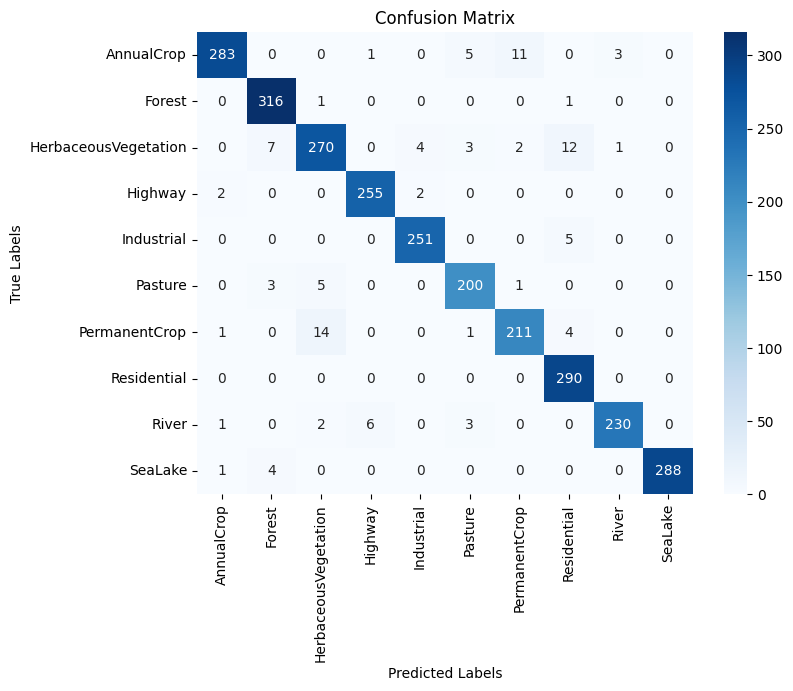

                      precision    recall  f1-score   support

          AnnualCrop       0.98      0.93      0.96       303
              Forest       0.96      0.99      0.98       318
HerbaceousVegetation       0.92      0.90      0.91       299
             Highway       0.97      0.98      0.98       259
          Industrial       0.98      0.98      0.98       256
             Pasture       0.94      0.96      0.95       209
       PermanentCrop       0.94      0.91      0.93       231
         Residential       0.93      1.00      0.96       290
               River       0.98      0.95      0.97       242
             SeaLake       1.00      0.98      0.99       293

            accuracy                           0.96      2700
           macro avg       0.96      0.96      0.96      2700
        weighted avg       0.96      0.96      0.96      2700

Final Accuracy: 96.07%


In [39]:
evaluate_model(model_64, test_generator, y_test, class_names=categories)

### 128 resizing

In [18]:
# Create the model
model_128 = build_model()

#### 🏋️ Training Process

```python
history = model.fit(
    train_generator,
    epochs=60,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)
```
- Trains up to 60 epochs with validation monitoring.
- Uses generators for memory-efficient data loading.

---

In [20]:
# Train the model
history = model_128.fit(
    train_generator,
    epochs=60,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/60
591/591 [==============================] - 66s 105ms/step - loss: 1.1361 - accuracy: 0.5944 - val_loss: 1.2718 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 2/60
591/591 [==============================] - 61s 104ms/step - loss: 0.8297 - accuracy: 0.7008 - val_loss: 1.2596 - val_accuracy: 0.5694 - lr: 0.0010
Epoch 3/60
591/591 [==============================] - 62s 105ms/step - loss: 0.7065 - accuracy: 0.7486 - val_loss: 1.1165 - val_accuracy: 0.6606 - lr: 0.0010
Epoch 4/60
591/591 [==============================] - 62s 104ms/step - loss: 0.6093 - accuracy: 0.7895 - val_loss: 0.6681 - val_accuracy: 0.7846 - lr: 0.0010
Epoch 5/60
591/591 [==============================] - 62s 105ms/step - loss: 0.5394 - accuracy: 0.8132 - val_loss: 1.8904 - val_accuracy: 0.6370 - lr: 0.0010
Epoch 6/60
591/591 [==============================] - 62s 105ms/step - loss: 0.4947 - accuracy: 0.8312 - val_loss: 1.0402 - val_accuracy: 0.6789 - lr: 0.0010
Epoch 7/60
591/591 [==============================] 

85/85 [==============================] - 1s 9ms/step


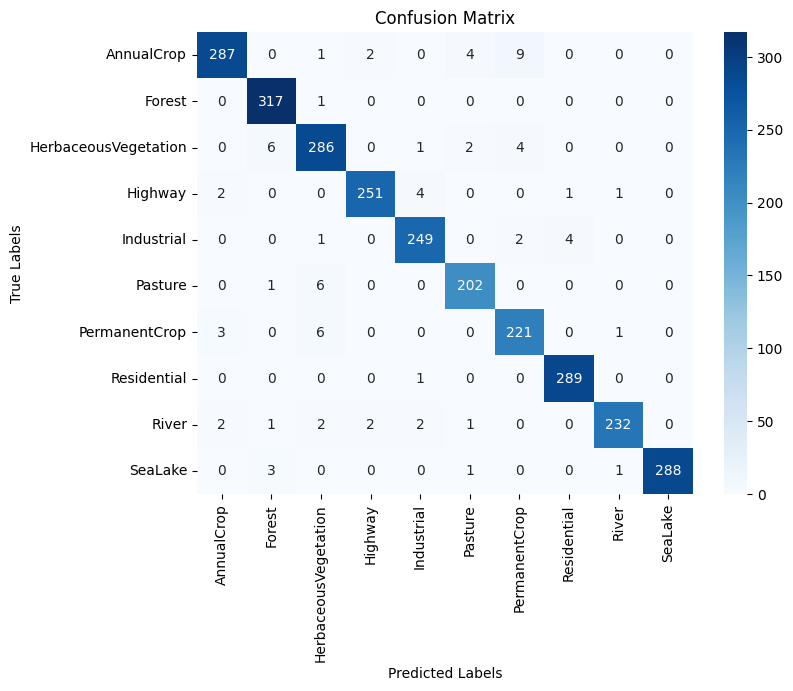

                      precision    recall  f1-score   support

          AnnualCrop       0.98      0.95      0.96       303
              Forest       0.97      1.00      0.98       318
HerbaceousVegetation       0.94      0.96      0.95       299
             Highway       0.98      0.97      0.98       259
          Industrial       0.97      0.97      0.97       256
             Pasture       0.96      0.97      0.96       209
       PermanentCrop       0.94      0.96      0.95       231
         Residential       0.98      1.00      0.99       290
               River       0.99      0.96      0.97       242
             SeaLake       1.00      0.98      0.99       293

            accuracy                           0.97      2700
           macro avg       0.97      0.97      0.97      2700
        weighted avg       0.97      0.97      0.97      2700

Final Accuracy: 97.11%


In [21]:
# Evaluate the model on test data
evaluate_model(model_128, test_generator, y_test, categories)

#### ✅ Final Accuracy

```text
Final Accuracy Achieved: 97%
```
- High classification performance on EuroSAT dataset.
- Suggests strong model generalization and effective architecture.

#### Plot Accuracy and Loss Curves

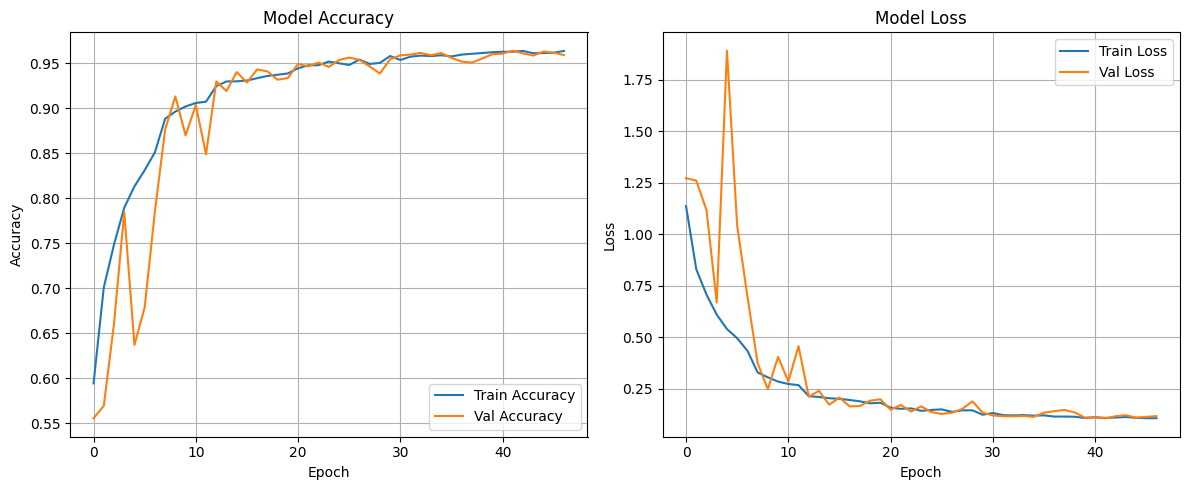

In [34]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
skip

#### Model Saving

In [22]:
model_128.save('better_cnn_model.h5')

In [ ]:
skip

## Import and Test Model

In [23]:
from keras.models import load_model

In [28]:
model = load_model("best_cnn_model.h5", compile=False)

85/85 [==============================] - 1s 10ms/step


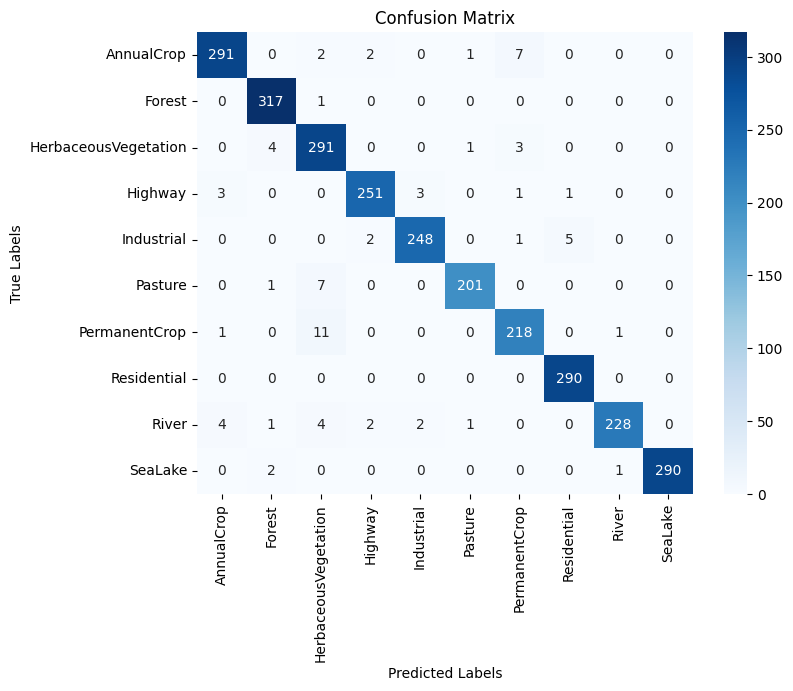

                      precision    recall  f1-score   support

          AnnualCrop       0.97      0.96      0.97       303
              Forest       0.98      1.00      0.99       318
HerbaceousVegetation       0.92      0.97      0.95       299
             Highway       0.98      0.97      0.97       259
          Industrial       0.98      0.97      0.97       256
             Pasture       0.99      0.96      0.97       209
       PermanentCrop       0.95      0.94      0.95       231
         Residential       0.98      1.00      0.99       290
               River       0.99      0.94      0.97       242
             SeaLake       1.00      0.99      0.99       293

            accuracy                           0.97      2700
           macro avg       0.97      0.97      0.97      2700
        weighted avg       0.97      0.97      0.97      2700

Final Accuracy: 97.22%


In [29]:
evaluate_model(model, test_generator, y_test, categories)

### Test Prediction

In [30]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def predict_image(img_path, model, class_names):
    # Step 1: Load image
    original_img = image.load_img(img_path)
    img = image.load_img(img_path, target_size=(128, 128))  # resize to match input

    # Step 2: Convert to array
    img_array = image.img_to_array(img)

    # Step 3: Normalize (scale to 0-1)
    img_array = img_array / 255.0

    # Step 4: Expand dimensions (make it batch-like)
    img_batch = np.expand_dims(img_array, axis=0)

    # Step 5: Predict
    prediction = model.predict(img_batch)
    class_index = np.argmax(prediction)

    # Step 6: Show result
    predicted_label = class_names[class_index]
    print(f"Predicted Class: {predicted_label} ({prediction[0][class_index]*100:.2f}%)")

    # Optional: Display the image
    plt.imshow(original_img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 131ms/step
Predicted Class: River (91.07%)


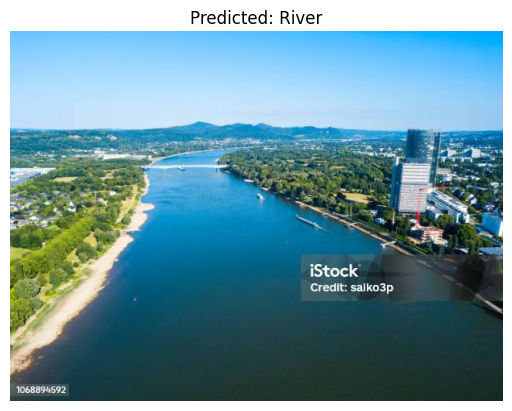

In [31]:
predict_image("C:/Users/Mostafa/EuroSAT/Testing/river.jpg", model, categories)